# Overview

This notebook represents efforts to predict trends in the telecommunication data that was investigated in the EDA notebook. For initial context, it is recommended to first read the README file. It is helpful to scan through the EDA first before this notebook as well to understand some of the strategies implemented in this notebook.

The problem: SyriaTel (a telecommunications company in Syria) is using a US-based telecom dataset surrounding the idea of customer churn in order to decrease losses involved in losing customers.
Main considerations for this problem:
* Business consideration: Identify customers that are likely to churn and implement a strategy, such as discounted rates for x number of months, to retain these customers.
* Evaluation consideration: More money will be lost on a False Negative (customer that is predicted to be retained but actually churned) than on a False Positive (customer that is predicted to churn but actually is retained) because it is assumed that it is more costly to replace the False Negative with a new customer and lose the stream of income from this churned customer than it is to implement a retention strategy (i.e. discounted rate) on a customer that does not need it and simply lose the difference between what they would have paid versus the discounted payment stream. For this reason, an F-2 Score will be used to evaluate model success because this metric penalizes False Negatives more than False Positives.
* It should also be noted that F-2 Score is used instead of another metric like recall because F-2 will penalize both FPs and FNs, which is important because both of these cases negatively affect the company.

# Modeling Preparation

## Imports and Some Dtype Conversions

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.svm import SVC  
from sklearn import svm

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import fbeta_score, accuracy_score, make_scorer
from sklearn.metrics import plot_confusion_matrix

In [2]:
# import dataset
df = pd.read_csv('..\\data\\telecom_data.csv')

# Handle object types for international plan and voice mail plan
df.loc[df['international plan'] == 'no', 'international plan'] = 0
df.loc[df['international plan'] == 'yes', 'international plan'] = 1 

df.loc[df['voice mail plan'] == 'no', 'voice mail plan'] = 0
df.loc[df['voice mail plan']== 'yes', 'voice mail plan'] = 1

# Change churn to values: 1 (churned/True) 0 (no churn/False)
df.loc[df['churn'] == True, 'churn'] = 1
df.loc[df['churn'] == False, 'churn'] = 0

# going to create backup df and drop phone number from original df
# phone number could be used as unique id, but it doesn't seem necessary
df_backup = df.copy()
df = df.drop(['phone number'], axis=1)

# casting int values to churn, voice mail plan, and international plan cols
objs = ['international plan', 'voice mail plan', 'churn']

for o in objs:
    df = df.astype({o: int})
    
# dropping area code
df = df.drop(['area code'], axis=1)

# check df
df.head()

,state,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


Handle international calls to bin them into categories easier.

In [3]:
# handle international calls to bin them into categories easier.
df['total intl calls'].value_counts()

3     668
4     619
2     489
5     472
6     336
7     218
1     160
8     116
9     109
10     50
11     28
0      18
12     15
13     14
15      7
14      6
18      3
16      2
19      1
17      1
20      1
Name: total intl calls, dtype: int64

{'whiskers': [<matplotlib.lines.Line2D at 0x1d6019d90a0>,
 'caps': [<matplotlib.lines.Line2D at 0x1d6019d9760>,
 'boxes': [<matplotlib.lines.Line2D at 0x1d6019c2d00>],
 'medians': [<matplotlib.lines.Line2D at 0x1d6019d9e20>],
 'fliers': [<matplotlib.lines.Line2D at 0x1d601a251c0>],
 'means': []}

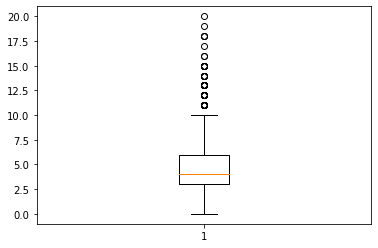

In [4]:
plt.boxplot(df['total intl calls'])

In [5]:
df['total intl calls'].describe()

count    3333.000000
mean        4.479448
std         2.461214
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max        20.000000
Name: total intl calls, dtype: float64

In [6]:
# range is 0-20 for international calls with most concentrated from 0-10
# I will bin into cats: low, moderate, and high with values <3, 3-6, and >6

list_tmp = []

for index, row in df.iterrows():
    if row['total intl calls'] < 3:
        list_tmp.append('low')
    elif row['total intl calls'] > 6:
        list_tmp.append('high')
    else:
        list_tmp.append('moderate')

df['total_intl_calls'] = list_tmp

df['total_intl_calls'].describe()

count         3333
unique           3
top       moderate
freq          2095
Name: total_intl_calls, dtype: object

## What would be the % chance of guessing correctly if the customer was assumed to not churn?

In [7]:
1-df.churn.mean()

0.8550855085508551

Guessing "not churned" for every customer would yield about an 85.5% chance of guessing correctly.

## Handle datatypes

Handle state and total_intl_calls object types. Turn these into integers for later modeling.

In [8]:
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA",
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA",
          "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY",
          "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX",
          "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

In [9]:
state_int = []
for i, row in df.iterrows():
    state_int.append(states.index(row['state']))

In [10]:
df['state_int'] = state_int

States in the dataset are alphabetically ordered such that Alabama is 0 and Wyoming is 50.

In [11]:
intl_calls_int = []
for i, row in df.iterrows():
    if row['total_intl_calls'] == 'low':
        intl_calls_int.append(0)
    elif row['total_intl_calls'] == 'moderate':
        intl_calls_int.append(1)
    else:
        intl_calls_int.append(2)

df['intl_calls_bins'] = intl_calls_int

Total international calls is now split into 0, 1, and 2 instead of low, moderate, and high. 
The new columns correspond to the following: 0 represents customers with less than 3 international calls, 1 represents customers with between 3 and 6 international calls, and 6 represents customers with over 6 international calls.

## Feature Engineering: Totals for Charge, Minutes, and Calls

To reduce the number of variables and redundancies in the dataset, total calls, total charge, and total minutes will represent totals for each category. These new categories will not include international call data.

In [12]:
df['total_calls'] = df.apply(lambda x: x['total night calls'] + x['total day calls'] + x['total night calls'], 
                               axis=1)
df['total_charge']= df.apply(lambda x: x['total day charge'] + x['total eve charge'] + x['total night charge'],
                                             axis=1)
df['total_minutes'] = df.apply(lambda x: x['total day minutes'] + x['total eve minutes'] + x['total night minutes'],
                                             axis=1)

## Define X and y and Normalize the Data

In [13]:
y = df['churn']

# dropping # vmail messages because its distribution isn't normal
# drop redundancies now that there are total charge, minutes, and calls cols.
# dropping any other columns that have been replaced with new ones.

X = df.drop(['churn', 'total intl calls', 'number vmail messages',
             'total_intl_calls', 'state', 'total day minutes',
             'total day calls', 'total day charge', 'total eve minutes',
             'total eve calls', 'total eve charge', 'total night minutes',
             'total night calls', 'total night charge'], axis=1)

## Train-test-split and SMOTE

The target feature has imbalance because customers that churned only represent about 14.5% of the data. Synthetic Minority Oversampling Technique (SMOTE) will be implemented to create balance in the target feature such that the models do not overlook the minority class (churned customers).

In [14]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=27)

# Fixing class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train)

## OHE and Normalize

Avoiding data leakage by transforming after the split

In [15]:
# Define categorical columns for OHE
cats = ['state_int', 'international plan', 'intl_calls_bins',
        'customer service calls', 'voice mail plan']

In [16]:
# Seperate data into categorical for train and test sets
X_train_cats = X_train_resampled[cats]
X_test_cats = X_test[cats]

# handle categorical values
ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

# OHE for training categoricals
ohe.fit(X_train_cats)
X_train_ohe = pd.DataFrame(
    ohe.transform(X_train_cats),
    index=X_train_cats.index,
    columns=ohe.get_feature_names()
)

# OHE for testing categoricals
ohe.fit(X_test_cats)
X_test_ohe = pd.DataFrame(
    ohe.transform(X_test_cats),
    index=X_test_cats.index,
    columns=ohe.get_feature_names()
)

# Scaling variables to work well with OHE data -scale train and test data
X_train_numerics = X_train_resampled.drop(cats, axis=1)
X_test_numerics = X_test.drop(cats, axis=1)

scaler = MinMaxScaler()

scaler.fit(X_train_numerics)
X_train_scaled = pd.DataFrame(
    scaler.transform(X_train_numerics),
    index=X_train_numerics.index,
    columns=X_train_numerics.columns
)

scaler.fit(X_train_numerics)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_numerics),
    index=X_test_numerics.index,
    columns=X_test_numerics.columns
)


# Concatenate and replace X_train and X_test with OHE+scaled data
X_train_resampled = pd.DataFrame()
X_train_resampled = pd.concat([X_train_scaled, X_train_ohe], axis=1)

X_test = pd.DataFrame()
X_test = pd.concat([X_test_scaled, X_test_ohe], axis=1)

To clarify the new confusing column names ('x0_0' and so on), the following list is provided to retain what each column refers to:
* First 51 columns (x0_0-x0_50) refer to the states
* The next two columns (x1_0 & x1_1) refer to whether or not the customer has an international plan.
* Columns x2_0-x2_2 refer to the frequency (low, moderate, high) of international calls.
* Columns x3_0-x3_9 refer to how many calls to customer service the customer has completed.
* The last two columns indicate whether or not the customer has a voice mail plan.

## Confusion Matrix Helper Function

In [17]:
# This function prints out a string of totals for TP, TN, FP, & FN
def conf_matrix(y_true, y_pred):
    cm = {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0}
    
    for ind, label in enumerate(y_true):
        pred = y_pred[ind]
        if label == 1:
            # CASE: TP 
            if label == pred:
                cm['TP'] += 1
            # CASE: FN
            else:
                cm['FN'] += 1
        else:
            # CASE: TN
            if label == pred:
                cm['TN'] += 1
            # CASE: FP
            else:
                cm['FP'] += 1
    return cm

# Baseline Model - Logistic Regression

## Fit data to model

In [18]:
# model
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear',
                            random_state=1)
model_log = logreg.fit(X_train_resampled, y_train_resampled)
model_log

LogisticRegression(C=1000000000000.0, fit_intercept=False, random_state=1,
                   solver='liblinear')

## Evaluate

In [19]:
y_hat_train = logreg.predict(X_train_resampled)

train_residuals = np.abs(y_train_resampled - y_hat_train)
print(pd.Series(train_residuals, name="Residuals (counts)").value_counts())
print()
print(pd.Series(train_residuals, name="Residuals (proportions)").value_counts(normalize=True))

0    3317
1     925
Name: Residuals (counts), dtype: int64

0    0.781942
1    0.218058
Name: Residuals (proportions), dtype: float64


In [20]:
print(confusion_matrix(y_train_resampled, y_hat_train))  
print(classification_report(y_train_resampled, y_hat_train)) 
print("The accuracy score is" + " "+ str(accuracy_score(y_train_resampled, y_hat_train)))

[[1634  487]
 [ 438 1683]]
              precision    recall  f1-score   support

           0       0.79      0.77      0.78      2121
           1       0.78      0.79      0.78      2121

    accuracy                           0.78      4242
   macro avg       0.78      0.78      0.78      4242
weighted avg       0.78      0.78      0.78      4242

The accuracy score is 0.7819424799622819


In [21]:
y_hat_test = logreg.predict(X_test)

test_residuals = np.abs(y_test - y_hat_test)
print(pd.Series(test_residuals, name="Residuals (counts)").value_counts())
print()
print(pd.Series(test_residuals, name="Residuals (proportions)").value_counts(normalize=True))

print(confusion_matrix(y_test, y_hat_test))  
print(classification_report(y_test, y_hat_test)) 
print("The accuracy score is" + " "+ str(accuracy_score(y_test, y_hat_test)))

0    630
1    204
Name: Residuals (counts), dtype: int64

0    0.755396
1    0.244604
Name: Residuals (proportions), dtype: float64
[[545 184]
 [ 20  85]]
              precision    recall  f1-score   support

           0       0.96      0.75      0.84       729
           1       0.32      0.81      0.45       105

    accuracy                           0.76       834
   macro avg       0.64      0.78      0.65       834
weighted avg       0.88      0.76      0.79       834

The accuracy score is 0.7553956834532374


In [22]:
conf_matrix(y_test, y_hat_test)

{'TP': 85, 'TN': 545, 'FP': 184, 'FN': 20}

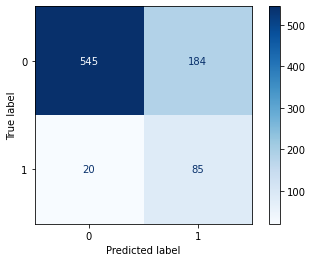

In [23]:
plot_confusion_matrix(logreg, X_test, y_test,
                     cmap=plt.cm.Blues)
plt.show()

In [24]:
# create list for storing F-Beta2 scores for each model
fbeta2_scores = []

f = fbeta_score(y_test, y_hat_test, beta=2.0)
fbeta2_scores.append(round(f, 3))
print(fbeta2_scores)

[0.617]


Logistic Regression results:
* Both accuracy scores are below a the strategy of simply guessing "not churned" for every customer.
* It will be key to reduce the number of customers that are identified as retained but actually churned. Ideally everyone that can be identified as churning will be retained with some kind of strategy.
* This model produces a lot of false positives, which ultimately penalized the F2 score.

# Model 2 - RF

## Fit model

In [25]:
# random forest model
forest = RandomForestClassifier(n_estimators=100, max_depth=13, random_state=1)
forest.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_depth=13, random_state=1)

## Evaluate

In [26]:
def plot_feature_importances(model):
    n_features = X_train_resampled.shape[1]
    plt.figure(figsize=(8,16))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train_resampled.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

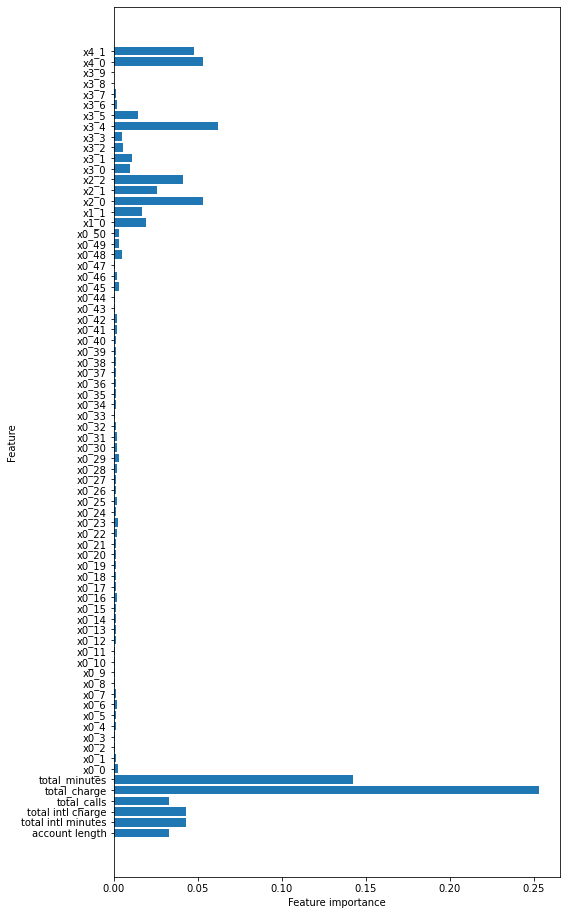

In [27]:
plot_feature_importances(forest)

In [28]:
# Training Accuracy
forest.score(X_train_resampled, y_train_resampled)

0.9127769919849128

In [29]:
# Testing Accuracy
forest.score(X_test, y_test)

0.9136690647482014

In [30]:
y_hat_train = forest.predict(X_train_resampled)

train_residuals = np.abs(y_train_resampled - y_hat_train)
print(pd.Series(train_residuals, name="Residuals (counts)").value_counts())
print()
print(pd.Series(train_residuals, name="Residuals (proportions)").value_counts(normalize=True))

print(confusion_matrix(y_train_resampled, y_hat_train))  
print(classification_report(y_train_resampled, y_hat_train)) 
print("The accuracy score is" + " "+ str(accuracy_score(y_train_resampled, y_hat_train)))

0    3872
1     370
Name: Residuals (counts), dtype: int64

0    0.912777
1    0.087223
Name: Residuals (proportions), dtype: float64
[[2044   77]
 [ 293 1828]]
              precision    recall  f1-score   support

           0       0.87      0.96      0.92      2121
           1       0.96      0.86      0.91      2121

    accuracy                           0.91      4242
   macro avg       0.92      0.91      0.91      4242
weighted avg       0.92      0.91      0.91      4242

The accuracy score is 0.9127769919849128


In [31]:
y_hat_test = forest.predict(X_test)

test_residuals = np.abs(y_test - y_hat_test)
print(pd.Series(test_residuals, name="Residuals (counts)").value_counts())
print()
print(pd.Series(test_residuals, name="Residuals (proportions)").value_counts(normalize=True))

print(confusion_matrix(y_test, y_hat_test))  
print(classification_report(y_test, y_hat_test)) 
print("The accuracy score is" + " "+ str(accuracy_score(y_test, y_hat_test)))

0    762
1     72
Name: Residuals (counts), dtype: int64

0    0.913669
1    0.086331
Name: Residuals (proportions), dtype: float64
[[675  54]
 [ 18  87]]
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       729
           1       0.62      0.83      0.71       105

    accuracy                           0.91       834
   macro avg       0.80      0.88      0.83       834
weighted avg       0.93      0.91      0.92       834

The accuracy score is 0.9136690647482014


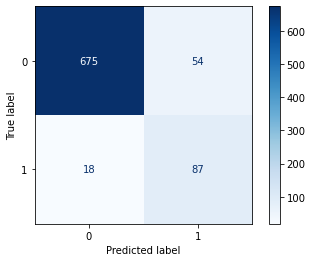

In [32]:
plot_confusion_matrix(forest, X_test, y_test,
                     cmap=plt.cm.Blues)
plt.show()

In [33]:
f = fbeta_score(y_test, y_hat_test, beta=2.0)
fbeta2_scores.append(round(f, 3))
fbeta2_scores

[0.617, 0.775]

# Model 3 - Optimize RF Model

## Fit and use GridSearchCV to find best parameters

In [34]:
# FBeta2 Scorer
ftwo_scorer = make_scorer(fbeta_score, beta=2)

In [35]:
# Using a pipeline to select for optimal parameters in the RF Classifier
pipe = Pipeline([('clf', RandomForestClassifier(random_state=1))])

grid_params = [{'clf__n_estimators': [100, 1000],
                'clf__criterion': ['gini', 'entropy'],
                'clf__max_depth': [None, 1, 5, 7, 11, 13, 17, 19],
                'clf__min_samples_split': [2, 5, 10],
                'clf__min_samples_leaf': [2, 3, 4, 5]
               }]

# grid search
gs = GridSearchCV(estimator=pipe,
                  param_grid=grid_params,
                  scoring=ftwo_scorer,
                  cv=5)

# Fit using grid search
gs.fit(X_train_resampled, y_train_resampled)

# Best F-2 Score
print('Best F-2 Score: %.3f' % gs.best_score_)

# Best params
print('\nBest params:\n', gs.best_params_)

Best F-2 Score: 0.844

Best params:
 {'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 1000}


This GridSearchCV code took my machine about 40 minutes to run.

In [36]:
forest = RandomForestClassifier(n_estimators=1000, criterion='entropy', 
                                max_depth=None, min_samples_leaf=2,
                                min_samples_split=2, random_state=1)
forest.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(criterion='entropy', min_samples_leaf=2,
                       n_estimators=1000, random_state=1)

## Evaluate

In [37]:
# Training Accuracy
forest.score(X_train_resampled, y_train_resampled)

0.974068835454974

In [38]:
# Testing Accuracy
forest.score(X_test, y_test)

0.9280575539568345

In [39]:
print(classification_report(y_train_resampled, y_hat_train)) 
print(classification_report(y_test, y_hat_test)) 

              precision    recall  f1-score   support

           0       0.87      0.96      0.92      2121
           1       0.96      0.86      0.91      2121

    accuracy                           0.91      4242
   macro avg       0.92      0.91      0.91      4242
weighted avg       0.92      0.91      0.91      4242

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       729
           1       0.62      0.83      0.71       105

    accuracy                           0.91       834
   macro avg       0.80      0.88      0.83       834
weighted avg       0.93      0.91      0.92       834



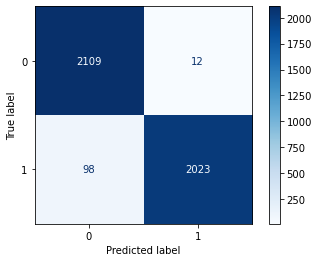

In [40]:
plot_confusion_matrix(forest, X_train_resampled, y_train_resampled,
                     cmap=plt.cm.Blues)
plt.show()

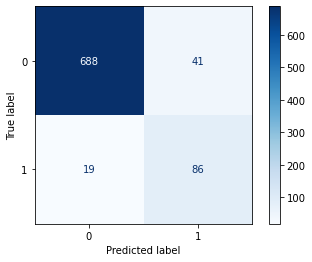

In [41]:
plot_confusion_matrix(forest, X_test, y_test,
                     cmap=plt.cm.Blues)
plt.show()

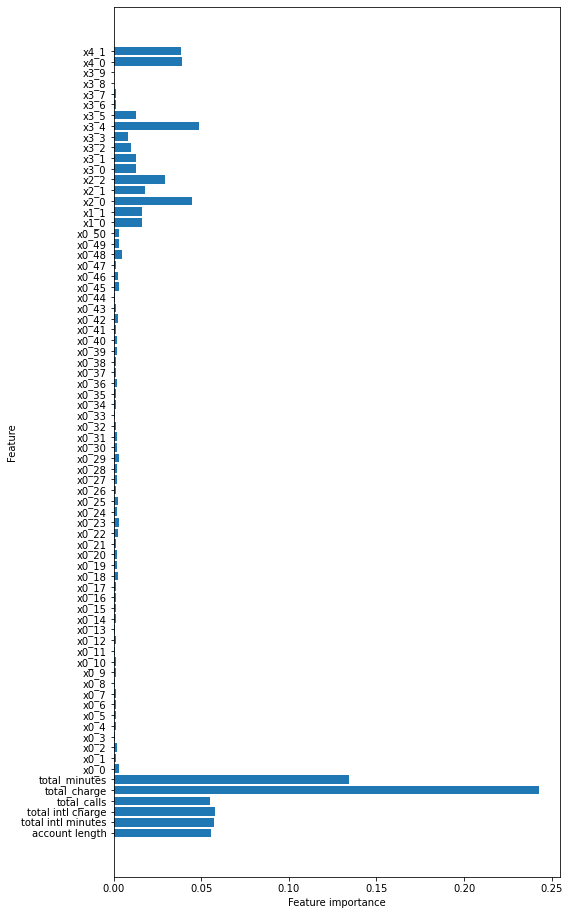

In [42]:
plot_feature_importances(forest)

In [43]:
y_hat_test = forest.predict(X_test)
f = fbeta_score(y_test, y_hat_test, beta=2.0)
fbeta2_scores.append(round(f, 3))
fbeta2_scores

[0.617, 0.775, 0.786]

# Model 4 - Optimize RF Model (2nd Attempt)

Attempting to reduce runtime by decreasing parameters a bit, but this code still does take a while to run.

To avoid overfitting in the RF Model, the following strategies will be utilized:
* Use less features (use something like 50% of total features for the max features parameter).
* Keep n_estimators large because the more trees there are, the less likely it is to overfit.

## Optimize RF Parameters and Fit

In [44]:
# Using a pipeline to select for optimal parameters in the RF Classifier
pipe = Pipeline([('clf', RandomForestClassifier(random_state=1))])

grid_params = [{'clf__n_estimators': [100],
                'clf__criterion': ['entropy'],
                'clf__max_depth': [None, 1, 7, 15],
                'clf__min_samples_split': [2, 5, 10],
                'clf__min_samples_leaf': [2, 3, 4, 5],
                'clf__max_features': [37]     #this is 50% of total features
               }]

# grid search
gs = GridSearchCV(estimator=pipe,
                  param_grid=grid_params,
                  scoring=ftwo_scorer,
                  cv=5)

# Fit using grid search
gs.fit(X_train_resampled, y_train_resampled)

# Best F-2 Score
print('Best F-2 Score: %.3f' % gs.best_score_)

# Best params
print('\nBest params:\n', gs.best_params_)

Best F-2 Score: 0.874

Best params:
 {'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__max_features': 37, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}


In [45]:
forest = RandomForestClassifier(n_estimators=100, criterion='entropy', 
                                max_depth=None, min_samples_leaf=2,
                                min_samples_split=2, random_state=1,
                                max_features=37)
forest.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(criterion='entropy', max_features=37, min_samples_leaf=2,
                       random_state=1)

## Evaluate

In [46]:
# Training Accuracy
forest.score(X_train_resampled, y_train_resampled)

0.9976426214049976

In [47]:
# Testing Accuracy
forest.score(X_test, y_test)

0.9364508393285371

In [48]:
print(classification_report(y_train_resampled, y_hat_train)) 
print(classification_report(y_test, y_hat_test)) 

              precision    recall  f1-score   support

           0       0.87      0.96      0.92      2121
           1       0.96      0.86      0.91      2121

    accuracy                           0.91      4242
   macro avg       0.92      0.91      0.91      4242
weighted avg       0.92      0.91      0.91      4242

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       729
           1       0.68      0.82      0.74       105

    accuracy                           0.93       834
   macro avg       0.83      0.88      0.85       834
weighted avg       0.94      0.93      0.93       834



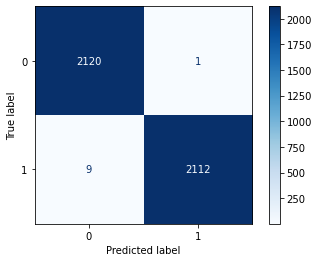

In [49]:
plot_confusion_matrix(forest, X_train_resampled, y_train_resampled,
                     cmap=plt.cm.Blues)
plt.show()

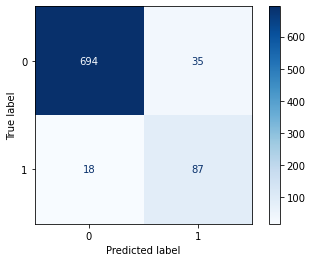

In [50]:
plot_confusion_matrix(forest, X_test, y_test,
                     cmap=plt.cm.Blues)
plt.show()

In [51]:
y_hat_test = forest.predict(X_test)
f = fbeta_score(y_test, y_hat_test, beta=2.0)
fbeta2_scores.append(round(f, 3))
fbeta2_scores

[0.617, 0.775, 0.786, 0.803]

# Model 5 - SVM

Creating an SVM model to attempt to lower runtime expense found in the RF models.

## Fit Baseline SVM, and then optimize parameters

* Multiple types of kernel functions were tested.
* Poly and rbf kernels were the strongest, but poly seems to be slightly better.

In [52]:
svclassifier = SVC(kernel='poly', C=1)  
svclassifier.fit(X_train_resampled, y_train_resampled) 
y_pred = svclassifier.predict(X_test)

In [53]:
print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred)) 
print("The accuracy score is" + " "+ str(accuracy_score(y_test, y_pred)))

[[608 121]
 [ 17  88]]
              precision    recall  f1-score   support

           0       0.97      0.83      0.90       729
           1       0.42      0.84      0.56       105

    accuracy                           0.83       834
   macro avg       0.70      0.84      0.73       834
weighted avg       0.90      0.83      0.86       834

The accuracy score is 0.8345323741007195


Optimize parameters to use in SVM

In [54]:
# This function finds the best parameters to use for an SVM classifier
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='poly'), param_grid, cv=nfolds, 
                               scoring=ftwo_scorer)
    grid_search.fit(X_train_resampled, y_train_resampled)
    grid_search.best_params_
    return grid_search.best_params_

In [55]:
svc_param_selection(X_train_resampled, y_train_resampled, 5)

{'C': 0.1, 'gamma': 0.1}

In [56]:
# using poly as the kernel works better
svclassifier = SVC(kernel='poly', C=.1, gamma=.1)  
svclassifier.fit(X_train_resampled, y_train_resampled) 
y_pred = svclassifier.predict(X_test)

## Evaluate

In [57]:
print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred)) 
print("The accuracy score is" + " "+ str(accuracy_score(y_test, y_pred)))

[[511 218]
 [ 25  80]]
              precision    recall  f1-score   support

           0       0.95      0.70      0.81       729
           1       0.27      0.76      0.40       105

    accuracy                           0.71       834
   macro avg       0.61      0.73      0.60       834
weighted avg       0.87      0.71      0.76       834

The accuracy score is 0.7086330935251799


In [58]:
y_pred_train = svclassifier.predict(X_train_resampled)
accuracy_score(y_train_resampled, y_pred_train)

0.7463460631777463

In [59]:
print(confusion_matrix(y_train_resampled, y_pred_train))  
print(classification_report(y_train_resampled, y_pred_train))

[[1441  680]
 [ 396 1725]]
              precision    recall  f1-score   support

           0       0.78      0.68      0.73      2121
           1       0.72      0.81      0.76      2121

    accuracy                           0.75      4242
   macro avg       0.75      0.75      0.75      4242
weighted avg       0.75      0.75      0.75      4242



In [60]:
f = fbeta_score(y_test, y_pred, beta=2.0)
fbeta2_scores.append(round(f, 3))
fbeta2_scores

[0.617, 0.775, 0.786, 0.803, 0.557]

# Model 6 - AdaBoost

The motivation for this model is to reduce runtime expense found in the RF model optimization processes and to perform better than the SVM model.

## Instantiate Model and Fit

In [61]:
from sklearn.ensemble import AdaBoostClassifier
adaboost_clf = AdaBoostClassifier(random_state=42)
adaboost_clf.fit(X_train_resampled, y_train_resampled)

AdaBoostClassifier(random_state=42)

## Evaluate

In [62]:
# AdaBoost model predictions for test and train sets
adaboost_train_preds = adaboost_clf.predict(X_train_resampled)
adaboost_test_preds = adaboost_clf.predict(X_test)

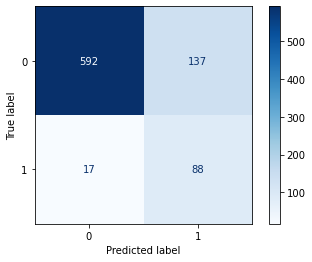

In [63]:
plot_confusion_matrix(adaboost_clf, X_test, y_test,
                     cmap=plt.cm.Blues)
plt.show()

In [64]:
print(classification_report(y_test, adaboost_test_preds)) 
print("The accuracy score is" + " "+ str(accuracy_score(y_test, adaboost_test_preds)))

              precision    recall  f1-score   support

           0       0.97      0.81      0.88       729
           1       0.39      0.84      0.53       105

    accuracy                           0.82       834
   macro avg       0.68      0.83      0.71       834
weighted avg       0.90      0.82      0.84       834

The accuracy score is 0.815347721822542


In [65]:
print(classification_report(y_train_resampled, adaboost_train_preds))
print("The accuracy score is" + " "+ str(accuracy_score(y_train_resampled, adaboost_train_preds)))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      2121
           1       0.82      0.80      0.81      2121

    accuracy                           0.81      4242
   macro avg       0.81      0.81      0.81      4242
weighted avg       0.81      0.81      0.81      4242

The accuracy score is 0.8147100424328148


In [66]:
f = fbeta_score(y_test, adaboost_test_preds, beta=2.0)
fbeta2_scores.append(round(f, 3))
fbeta2_scores

[0.617, 0.775, 0.786, 0.803, 0.557, 0.682]

Comments on AdaBoost Model:
* It is very fast
* It has a much higher rate of FPs compared to the RF models.
* It does not have as good of scoring (by any metric of comparison) as the RF models

## Tune Model with GridSearchCV and Run Again

In [67]:
gs = GridSearchCV(estimator=adaboost_clf,
                 param_grid={
                     'n_estimators': [25, 50, 100, 500],
                     'learning_rate': [.001, .01, .1, 1]
                 }, scoring=ftwo_scorer, cv=5)

gs.fit(X_train_resampled, y_train_resampled)
gs.best_params_

{'learning_rate': 1, 'n_estimators': 500}

In [68]:
adaboost_clf = AdaBoostClassifier(learning_rate=1, n_estimators=500,
                                  random_state=42)
adaboost_clf.fit(X_train_resampled, y_train_resampled)

AdaBoostClassifier(learning_rate=1, n_estimators=500, random_state=42)

In [69]:
# AdaBoost model predictions
adaboost_train_preds = adaboost_clf.predict(X_train_resampled)
adaboost_test_preds = adaboost_clf.predict(X_test)

print(classification_report(y_train_resampled, adaboost_train_preds))
print(classification_report(y_test, adaboost_test_preds))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      2121
           1       0.86      0.83      0.84      2121

    accuracy                           0.85      4242
   macro avg       0.85      0.85      0.85      4242
weighted avg       0.85      0.85      0.85      4242

              precision    recall  f1-score   support

           0       0.97      0.83      0.89       729
           1       0.41      0.83      0.55       105

    accuracy                           0.83       834
   macro avg       0.69      0.83      0.72       834
weighted avg       0.90      0.83      0.85       834



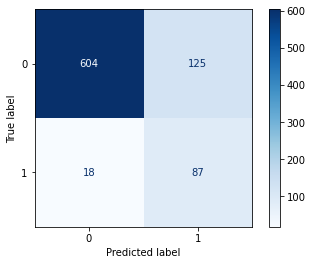

In [70]:
plot_confusion_matrix(adaboost_clf, X_test, y_test,
                     cmap=plt.cm.Blues)
plt.show()

In [71]:
f = fbeta_score(y_test, adaboost_test_preds, beta=2.0)
fbeta2_scores.append(round(f, 3))
fbeta2_scores

[0.617, 0.775, 0.786, 0.803, 0.557, 0.682, 0.688]

# RF Without State Column

The 'State' column is probably not particularly useful for SyriaTel, and none of the states seem to have super strong feature importance by themselves.

## Remove State Column and Prepare Dataset to Model

In [72]:
# Define X and y
y = df['churn']

# drop state_int column as well this time
X = df.drop(['churn', 'total intl calls', 'number vmail messages',
             'total_intl_calls', 'state', 'total day minutes',
             'total day calls', 'total day charge', 'total eve minutes',
             'total eve calls', 'total eve charge', 'total night minutes',
             'total night calls', 'total night charge', 'state_int'], axis=1)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=27)

# Fixing class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train)

# define categorical columns
cats = ['international plan', 'intl_calls_bins',
        'customer service calls', 'voice mail plan']

# Seperate data into categorical for train and test sets
X_train_cats = X_train_resampled[cats]
X_test_cats = X_test[cats]

# handle categorical values
ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

ohe.fit(X_train_cats)
X_train_ohe = pd.DataFrame(
    ohe.transform(X_train_cats),
    index=X_train_cats.index,
    columns=ohe.get_feature_names()
)

ohe.fit(X_test_cats)
X_test_ohe = pd.DataFrame(
    ohe.transform(X_test_cats),
    index=X_test_cats.index,
    columns=ohe.get_feature_names()
)

# Scaling variables to work well with OHE data
X_train_numerics = X_train_resampled.drop(cats, axis=1)
X_test_numerics = X_test.drop(cats, axis=1)

scaler = MinMaxScaler()

scaler.fit(X_train_numerics)
X_train_scaled = pd.DataFrame(
    scaler.transform(X_train_numerics),
    index=X_train_numerics.index,
    columns=X_train_numerics.columns
)

scaler.fit(X_train_numerics)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_numerics),
    index=X_test_numerics.index,
    columns=X_test_numerics.columns
)


# Concatenate
X_train_resampled = pd.DataFrame()
X_train_resampled = pd.concat([X_train_scaled, X_train_ohe], axis=1)

X_test = pd.DataFrame()
X_test = pd.concat([X_test_scaled, X_test_ohe], axis=1)

## Fit Model

In [73]:
# random forest model
forest = RandomForestClassifier(n_estimators=100, max_depth=13, 
                                random_state=69)
forest.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_depth=13, random_state=69)

## Evaluate

In [74]:
print(classification_report(y_train_resampled, y_hat_train)) 
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.87      0.96      0.92      2121
           1       0.96      0.86      0.91      2121

    accuracy                           0.91      4242
   macro avg       0.92      0.91      0.91      4242
weighted avg       0.92      0.91      0.91      4242

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       729
           1       0.71      0.83      0.77       105

    accuracy                           0.94       834
   macro avg       0.84      0.89      0.86       834
weighted avg       0.94      0.94      0.94       834



In [75]:
# Training Accuracy
forest.score(X_train_resampled, y_train_resampled)

0.9582743988684582

In [76]:
# Testing Accuracy
forest.score(X_test, y_test)

0.9304556354916067

In [77]:
final_cols = ['account length', 'total intl minutes', 'total intl charge',
               'total_calls', 'total_charge', 'total_minutes',
               'no international plan', 'has international plan',
               'low international calls', 'moderate international calls',
               'high international calls', '0 customer service calls',
               '1 customer service call', '2 customer service calls', 
               '3 customer service calls',
               '4 customer service calls', '5 customer service calls',
               '6 customer service calls', '7 customer service calls',
               '8 customer service calls', '9 customer service calls', 
               'no voice mail plan', 'has voice mail plan']

In [78]:
# Create table of feature importances and values
df_final_feature_importances = pd.DataFrame(index=(final_cols))
# df_final_feature_importances.set_axis([final_cols], axis=1)
df_final_feature_importances['feature importances values'] = forest.feature_importances_
df_final_feature_importances = df_final_feature_importances.sort_values(
    by=['feature importances values'], ascending=False)
df_final_feature_importances

,feature importances values
total_charge,0.261693
total_minutes,0.141425
4 customer service calls,0.063451
total intl minutes,0.061353
low international calls,0.059763
total intl charge,0.059315
no voice mail plan,0.055946
account length,0.053407
total_calls,0.050885
has voice mail plan,0.041485


In [79]:
# creating new feature importances plot function to allow for more 
# comprehensability for this plot, which will be used elsewhere as well.

def plot_feature_importances_final(model):
    y_ticks = ['account length', 'total intl minutes', 'total intl charge',
               'total_calls', 'total_charge', 'total_minutes',
               'no international plan', 'has international plan',
               'low international calls', 'moderate international calls',
               'high international calls', '0 customer service calls',
               '1 customer service call', '2 customer service calls', 
               '3 customer service calls',
               '4 customer service calls', '5 customer service calls',
               '6 customer service calls', '7 customer service calls',
               '8 customer service calls', '9 customer service calls', 
               'no voice mail plan', 'has voice mail plan']

    n_features = X_train_resampled.shape[1]
    plt.figure(figsize=(8,16))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), y_ticks) 
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('Final Model Feature Importances')

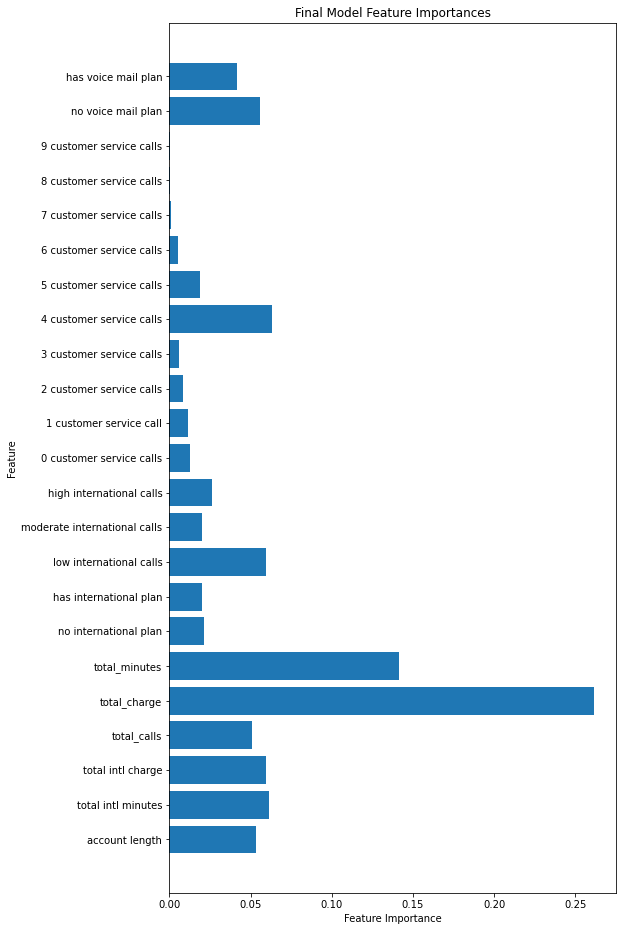

In [80]:
plot_feature_importances_final(forest)

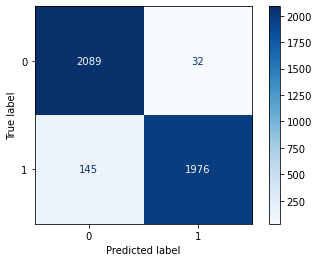

In [81]:
plot_confusion_matrix(forest, X_train_resampled, y_train_resampled,
                     cmap=plt.cm.Blues)
plt.show()

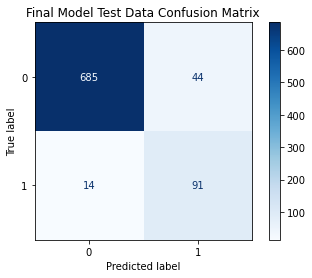

In [82]:
plot_confusion_matrix(forest, X_test, y_test,
                     cmap=plt.cm.Blues)
plt.title("Final Model Test Data Confusion Matrix")
plt.show()

In [83]:
y_hat_test = forest.predict(X_test)
f = fbeta_score(y_test, y_hat_test, beta=2.0)
fbeta2_scores.append(round(f, 3))
fbeta2_scores

[0.617, 0.775, 0.786, 0.803, 0.557, 0.682, 0.688, 0.82]

## Tune Model with GridSearchCV

In [84]:
forest = RandomForestClassifier(random_state=1)

gs = GridSearchCV(estimator=forest,
                 param_grid={
                     'n_estimators': [10, 100, 1000],    
                     'criterion': ['entropy', 'gini'],   
                     'max_depth': [None, 1, 7, 15, 23, 31],
                     'min_samples_split': [2, 5, 10],
                     'min_samples_leaf': [2, 3, 4, 5, 6]
                 }, scoring=ftwo_scorer, cv=5)

gs.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [None, 1, 7, 15, 23, 31],
                         'min_samples_leaf': [2, 3, 4, 5, 6],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 100, 1000]},
             scoring=make_scorer(fbeta_score, beta=2))

Approximately 42 minute runtime for this GridSearchCV.

In [85]:
# Best F-2 Score
print('Best F2 Score: %.3f' % gs.best_score_)

# Best params
print('\nBest params:\n', gs.best_params_)

Best F2 Score: 0.864

Best params:
 {'criterion': 'entropy', 'max_depth': 31, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1000}


In [86]:
forest = RandomForestClassifier(n_estimators=1000, criterion='entropy',
                                min_samples_leaf=2, min_samples_split=5,
                                max_depth=31, random_state=42)
forest.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(criterion='entropy', max_depth=31, min_samples_leaf=2,
                       min_samples_split=5, n_estimators=1000, random_state=42)

## Re-Evaluate

In [87]:
print(classification_report(y_train_resampled, y_hat_train, digits=4)) 
print(classification_report(y_test, y_hat_test, digits=4))

              precision    recall  f1-score   support

           0     0.8746    0.9637    0.9170      2121
           1     0.9596    0.8619    0.9081      2121

    accuracy                         0.9128      4242
   macro avg     0.9171    0.9128    0.9126      4242
weighted avg     0.9171    0.9128    0.9126      4242

              precision    recall  f1-score   support

           0     0.9800    0.9396    0.9594       729
           1     0.6741    0.8667    0.7583       105

    accuracy                         0.9305       834
   macro avg     0.8270    0.9032    0.8589       834
weighted avg     0.9415    0.9305    0.9341       834



In [88]:
# Training Accuracy
forest.score(X_train_resampled, y_train_resampled)

0.987977369165488

In [89]:
# Testing Accuracy
forest.score(X_test, y_test)

0.9268585131894485

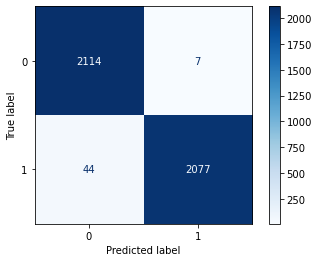

In [90]:
plot_confusion_matrix(forest, X_train_resampled, y_train_resampled,
                     cmap=plt.cm.Blues)
plt.show()

In [91]:
y_pred = forest.predict(X_test)
conf_matrix(y_test, y_pred)

{'TP': 86, 'TN': 687, 'FP': 42, 'FN': 19}

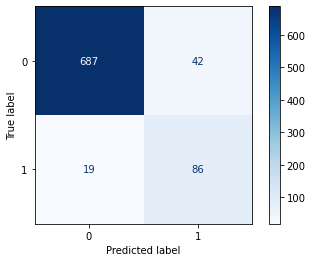

In [92]:
plot_confusion_matrix(forest, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

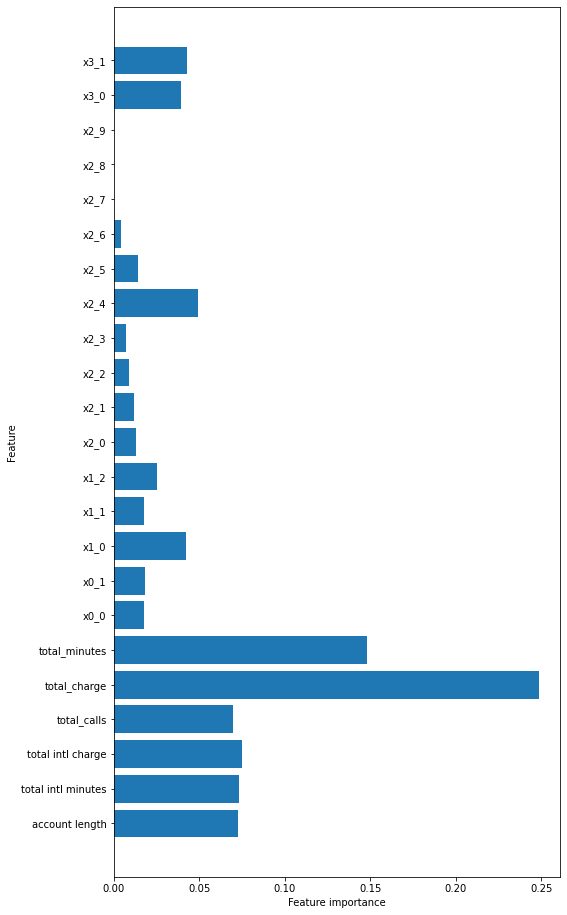

In [93]:
plot_feature_importances(forest)

In [94]:
y_hat_test = forest.predict(X_test)
f = fbeta_score(y_test, y_hat_test, beta=2.0)
fbeta2_scores.append(round(f, 3))
fbeta2_scores

[0.617, 0.775, 0.786, 0.803, 0.557, 0.682, 0.688, 0.82, 0.785]

Suppressing the following code because it produces a large file size for the image it makes.
The following code creates an image of a single tree in the forest in the section 8 tuned model.

In [95]:
# try to visualize the tree
# adapted from: https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c
# credits to Will Koehresen for the code above (link above)

# from sklearn.tree import export_graphviz
# # Export as dot file
# export_graphviz(forest.estimators_[3], out_file='tree.dot', 
#                 feature_names = X_train_resampled.columns.to_list(),
#                 class_names = 'churn',
#                 rounded = True, proportion = False, 
#                 precision = 3, filled = True)

# # Convert to png using system command (requires Graphviz)
# from subprocess import call
# call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# # Display in jupyter notebook
# from IPython.display import Image
# Image(filename = 'tree.png')

# Final Model Selection and Discussion

## Overview

The goal of this project is to reduce customer churn rate for SyriaTel. This dataset is based in the US, so it is important for model results to extrapolate well to an application in Syria (where SyriaTel is based). 
To reduce customer churn rate, it is important to identify customers that are likely to churn, why these customers churn, and deploy a customer retention strategy on these customers.

Main evaluation metrics to use and the basis of justification for utilizing these metrics:
* The main goal is to implement retention strategies such as offering discounted rates, better plans, etc. to customers identified as likely to churn.
* Customers that are classified as churning by the model will be offered a retention strategy that will probably cost money to implement, but it can be justified by retaining the customer in the long term.
* Accuracy is important for minimizing total false negatives and false positives. 
* False negatives (customers identified as retained but are not actually retained) are important to minimize because these are customers that "fell through the cracks" and left without any attempt to save their business.
* False positives are important to minimize because these customers will potentially represent an unneeded cost because they will be offered one of the retention strategies, which costs the company money, even though they don't need incentive to stay with the company. This loss could be countered with some type of survey to identify dissatisfied customers, but it is important to decrease the amount of false positives.
* False negatives (customers identified as not churning but actually churned) should be penalized more because these customers do not have the potential to be retained with any particular strategy, they simply fall through the cracks. This cost is greater than a decent retention strategy because the retention strategy will signify an initial cost, but it will allow for the customer to be retained for a longer time.

Other justifications for model selection:
* The model must have potential to extrapolate from this dataset (from a US-based company) to the stakeholder (SyriaTel).
* It is ideal for the model to be deployed somewhat quickly so that customers can be classified as likely to churn or not at the end of various time periods, and so that customer retention strategies can be deployed quickly.

Retention Strategies:
* If the customer has an international plan, then offer a certain amount of months for free. The international plan in this dataset doesn't seem to do anything (check EDA notebook), and it probably wouldn't be of any cost for this particular company to offer international plans free for an extended period. But this idea is one strategy for retaining customers with international plans.
* Offer a discount for call charges. Total charge was an important feature in most models, so it will be useful to offer discounts to retain customers. 
* Create better customer service methods and offer solutions quickly to customers that call multiple times.
* Have an effective international plan.

## Customer Retention Strategy and Evaluation Metric

Main Retention Strategy to Consider:
* Offer customers identified as likely to churn the option to have a discount such as 6 months at 50% off.

Items to consider:
* Assumptions have to be made in order to evaluate how effective the retention strategy will be.
* Assumption 1: average cost to acquire a new customer is around 300 dollars. Sources: https://www.forbes.com/sites/forbestechcouncil/2020/10/30/acquiring-subscribers-is-only-half-the-battle/https://www.entrepreneur.com/article/225415
* Average phone bill cost (in the US) for a single user: 70 dollars/month. Source: https://www.usmobile.com/blog/cut-cell-phone-bill/
* Assume that customers that leave the service will cost the company 370 dollars (cost of one month of service + cost to acquire new customer).
* For False Positive customers (model identifies customer as churning, but they do not churn), assume the cost to the company is (35 dollars* 6 months) = 210 dollars.
* For False Negative customers (model identifies as retained but they churn), assume the cost to the company is 370 dollars.
* For True Negative customers, assume the rate of retention (after offering the discount) is 80%. 
* The expected value gained for any True Negative customer is .8(-210+370) + .2(-370) = 54 dollars.

Discussion of Metric to Use (F-Beta2):
* A False Negative costs about 1.762 times as much as a False Positive from the above calculations. The metric will need to implement recognition of this discrepancy.
* Could use expected amount of money gained or lost.
* Use F-Beta with a beta value > 1 to penalize False Negatives more than False Positives.
* Due to the nature of making many assumptions in the previous calculations, F-Beta2 score will be used to compare model performance between each other. This scoring method ensures that FN's are penalized more than FP's. F-Beta2 will not necessarily penalize FN's exactly 1.762 times more than FP's, but it will give a good comparison between models that will offer a good estimation that doesn't have to rely on the assumptions made.


## Final Model and Inferences from the Model

In [96]:
fbeta2_scores

[0.617, 0.775, 0.786, 0.803, 0.557, 0.682, 0.688, 0.82, 0.785]

The first RF model without the state column performed the best in terms of F-2 Score.

### Review the top feature importances of the model

In [97]:
df_final_feature_importances.head(10)

,feature importances values
total_charge,0.261693
total_minutes,0.141425
4 customer service calls,0.063451
total intl minutes,0.061353
low international calls,0.059763
total intl charge,0.059315
no voice mail plan,0.055946
account length,0.053407
total_calls,0.050885
has voice mail plan,0.041485


By far the most important feature is total charge. It will be important to focus on discounting costs of customers that are predicted to churn. It would be worthwhile to  investigate better overall methods to decrease costs for customers.
The second most important feature is total minutes. This feature may coincide with total charge if it is the case that customers are charged per minute in this particular company. There are various business strategies that could reduce churn in this case such as rewarding customers for utilizing the service more or offering more comprehensive plans for customers such as unlimited calling.
The third most important feature is four customer service calls. In the EDA, customers with four or more calls to customer service were very likely to churn. It will be extremely important to improve customer service, especially for customers that call multiple times.

### Estimate money saved with this model

Without a retention strategy, how much money is lost? SyriaTel has millions of customers, but let's assume that there are one million customers at SyriaTel and account for lost money without a strategy. With the assumptions made in section 10.2, 370 dollars is lost for customers that are not identified as churning. 14.5% of customers in the original dataset churned. With one million customers total customers, that would represent a loss of business from 145,000 customers and $53.65M.

In the final model, the expected rate of FN's (customers that churn but are predicted as retained) is about 1.68%. The expected rate of TP's is about 5.28%. The expected rate of TN's is about 11%. Therefore, FN's will account for 16,800 customers, TP's will account for 52,800 customers, and TN's will account for 110,000 customers. The expected loss (derived from the calculations in section 10.2) equates to 6,216,000 dollars from FN's and  11,088,000 dollars from TP's. The expected gain from TN's is 5,940,000 dollars. In total, SyriaTel is expected to lose about 11,364,000 dollars with this retention strategy, but SyriaTel will save 42,286,000 dollars by implementing this strategy in comparison to having no strategy. 

### Conclusions

According to SyriaTel's LinkedIn, they have over eight million customers. With the retention strategy covered in this notebook, SyriaTel is estimated to save just over 338 million dollars. Obviously SyriaTel is based in Syria and probably does not use dollars, and the estimations for these calculations is based somewhat on US telecommunications data (reference section 10.2). However, the point of this notebook is that the model created allows for SyriaTel to save an enormous amount of money. There are also other considerations that can be inferred from this model that SyriaTel can make use of. For instance, this dataset highlights the need for good customer service, especially after the customer has contacted customer service previously. The dataset also highlights the need for a comprehensive international plan (if that plan is offered) because many customers with an international plan ended up churning in this dataset.

Further considerations:
* Tune estimation parameters to account for telecommunication data in Syria.
* Use a larger telecommunications dataset. There were 3,333 datapoints in this set, which is by no means a large dataset. A larger dataset will allow for more confidence in the predictive models covered in this notebook.
* Tune the hyperparameters in the model and re-adjust the model after more data has been collected.
* Ideally this model and various parameters would be adjusted and predictions would be created again after another time period has surpassed and customer churn rate can be re-evaluated. 
* There are other macroeconomic variables in Syria that will affect customer retention. Syria is not the most stable of areas, and the EU has even imposed sanctions on SyriaTel in the past (reference: https://www.reuters.com/article/us-syria-eu-sanctions-idUSTRE78N1DY20110924)